# Model-based RL: от MCTS к Dreamer

## Part #2: Обучение с использованием модели и внутренней мотивации на основе ошибки модели

В данной тетрадке поиграемся с вариациями табличного алгоритма Dyna-Q.

<img src="https://raw.githubusercontent.com/Tviskaron/mipt/master/2019/RL/10/dyna.png">

Представим, что модель среды обучается не моментально и может содержать ошибки, и посмотрим, как нам поможет в такой ситуации внутренняя мотивация и обучение не на отдельных случайных воображаемых переходах (как это сделано в Dyna-Q), а на целых траекториях по примеру метода Dreamer.

__NB__: Кстати, вот ссылка [link](https://lilianweng.github.io/posts/2018-04-08-policy-gradient/) на пост в блоге Lil'Log со второго семинара "Actor-Critics".

In [96]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

In [97]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
from functools import partial
from IPython.display import clear_output

%matplotlib inline

In [98]:
def show_progress(avg_returns):
    """
    Удобная функция, которая отображает прогресс обучения.
    """
    clear_output(True)
    plt.figure(figsize=[12, 4])
    plt.subplot(1, 1, 1)
    plt.plot(*zip(*avg_returns), label='Mean return')
    plt.legend(loc=4)
    plt.grid()
    plt.show()

def compare_logs(logs):
    """Функция сравнения кривых обучения"""
    plt.figure(figsize=[12, 6])
    for log, method_name in logs:
        plt.plot(*zip(*log), label=f'{method_name}')
        plt.legend()
    plt.grid()
    plt.show()

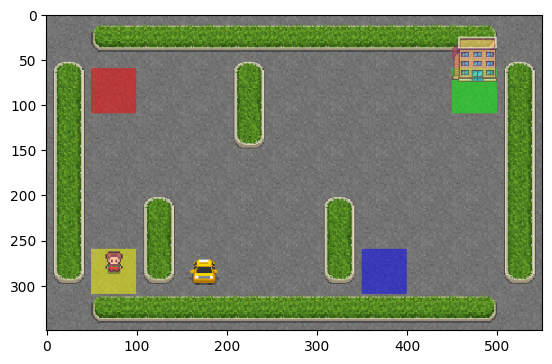

In [99]:
env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset(seed=13)
plt.imshow(env.render())

### Задание 1: Реализуйте методы класса Model, которые позволят вам сохранять и получать необходимые кортежи данных.

In [127]:
class Model:
    def __init__(self, n_states, n_actions, seed):
        # проинициализируйте атрибуты, необходимые вам для хранения модели (переходов и вознаграждения)
        # например, можно хранить [в виде таблицы] табличные функции
        # r: (s, a) -> r
        # next_s: (s, a) -> next_s
        # NB: мне было удобно дополнительно держать таблицы масок для посещенных состояний и пар (s, a)
        """<codehere>"""
        self.mask_state = np.zeros([n_states], dtype=int)
        self.mask_state_action = np.zeros([n_states, n_actions], dtype=int)
        self.r = np.zeros_like(self.mask_state_action, dtype=float)
        self.next_s = np.zeros_like(self.mask_state_action, dtype=int)
        """</codehere>"""
        self._rng = np.random.default_rng(seed)

    def add(self, s: int, a: int, r: float, next_s: int) -> float:
        # реализуйте мгновенное обучение модели для (s, a) -> r и (s, a) -> next_s
        """<codehere>"""
        self.mask_state[s] += 1
        self.mask_state_action[s][a] = 1
        self.r[s][a] = r 
        self.next_s[s][a] = next_s
        """</codehere>"""
        return r

    def sample_state(self):
        # просэмплируйте одно посещенное состояние
        """<codehere>"""
        s = self._rng.choice(np.flatnonzero(self.mask_state))
        """</codehere>"""
        return s

    def sample_action(self, s):
        # просэмплируйте одно совершаемое ранее действие
        """<codehere>"""
        a = self._rng.choice(np.flatnonzero(self.mask_state_action[s]))
        """</codehere>"""
        return a

    def predict_transition(self, s, a):
        # реализуйте [идеальное] предсказание модели перехода и модели вознаграждения
        """<codehere>"""
        next_s = self.next_s[s][a]
        """</codehere>"""
        return self.r[s, a], next_s

    def sample(self) -> tuple[int, int, float, int]:
        # реализуйте выбор одного случайного перехода (s, a, r, next_s)
        """<codehere>"""
        s = self.sample_state()
        a = self.sample_action(s)
        r, next_s = self.predict_transition(s, a)
        return s, a, r, next_s
        """</codehere>"""

In [130]:
class DynaQAgent:
    def __init__(self, n_states, n_actions, lr, gamma, eps, f_model, seed):
        self.Q = np.zeros((n_states, n_actions))
        self.model = f_model(n_states, n_actions, seed=seed)
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.n_actions = n_actions
        self._rng = np.random.default_rng(seed)
        
    def act(self, s):
        # выбираем действие, используя eps-greedy исследование среды
        # с вероятностью epsilon выбираем случайное действие, иначе
        # выполняем действие жадно, согласно текущей Q-таблице
        if self._rng.random() < self.eps:
            action = self._rng.choice(self.n_actions)
        else:
            action = np.argmax(self.Q[s])  # используем Q-функцию
        return action

    def update(self, s, a, r, s_n, update_model: bool):
        if update_model:
            r = self.model.add(s, a, r, s_n)

        # реализуйте шаг Q-обучения
        """<codehere>"""
        # получаем old_value (Q(s,a)) и next_max (max(Q(s', a')))
        Q_s_a = self.Q[s, a]
        V_sn = np.max(self.Q[s_n])

        td_error = r + self.gamma * V_sn - Q_s_a
        self.Q[s, a] += self.lr * td_error
        """</codehere>"""
        
    def dream(self, max_steps, **_):
        for _ in range(max_steps):
            # Добавьте шаг обучения с использованием модели на одном просэмплированном вашей моделью переходе
            """<codehere>"""
            m_s, m_a, m_r, m_next_s = self.model.sample()
            self.update(m_s, m_a, m_r, m_next_s, update_model=False)
            """</codehere>"""

In [129]:
def train(env, agent, n_episodes, on_model_updates, seed, show_progress_schedule=50, show_model_progres=False):
    avg_returns, returns_batch = [], []
    rng = np.random.default_rng(seed)

    for i in range(1, n_episodes):
        state, _ = env.reset(seed=int(rng.integers(10000000)))
        reward, episode_return = 0, 0

        while True:
            action = agent.act(state)

            # выполняем действие в среде
            next_state, reward, terminated, truncated, info = env.step(action)
            # шаг обучения
            agent.update(state, action, reward, next_state, update_model=True)
            state = next_state
            episode_return += reward
            done = terminated or truncated
            if done:
                break
            agent.dream(on_model_updates, state=state)

        returns_batch.append(episode_return)

        if i % show_progress_schedule == 0 and not show_model_progres:
            avg_returns.append((i, np.mean(returns_batch)))
            returns_batch = []
            
            show_progress(avg_returns)
            print(
                f"Episode: {i}, Return: {episode_return}, "
                f"AvgReturn[{show_progress_schedule}]: {avg_returns[-1][1]:.0f}"
            )
        if i % show_progress_schedule == 0 and show_model_progres:
            avg_model_knowledge = np.mean(
                agent.model.mask_state_action[agent.model.mask_state_action > 0]
            )
            avg_returns.append((i, avg_model_knowledge))
            returns_batch = []
            
            show_progress(avg_returns)

    return avg_returns

### Обычный Q-learning

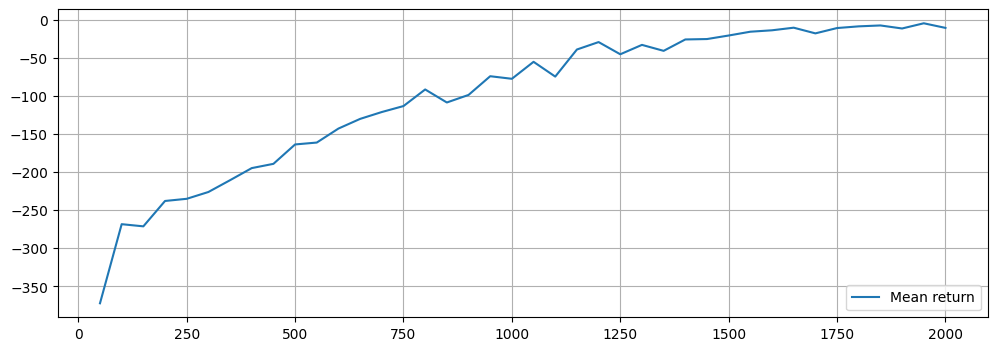

Episode: 2000, Return: -14, AvgReturn[50]: -10


In [116]:
env = gym.make("Taxi-v3")
seed = 1337
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.05, gamma=0.975, eps=0.1, seed=seed,
    f_model=Model
)

log_q = train(env, agent, n_episodes=2001, on_model_updates=0, seed=seed, show_progress_schedule=50)

### DynaQ

1. Сравните скорость обучения алгоритма Dyna-Q с параметром on_model_updates равным 10 и алгоритма Q-обучение.
2. Сравните скорость обучения при различных on_model_updates. В каком случае получились лучшие результаты?

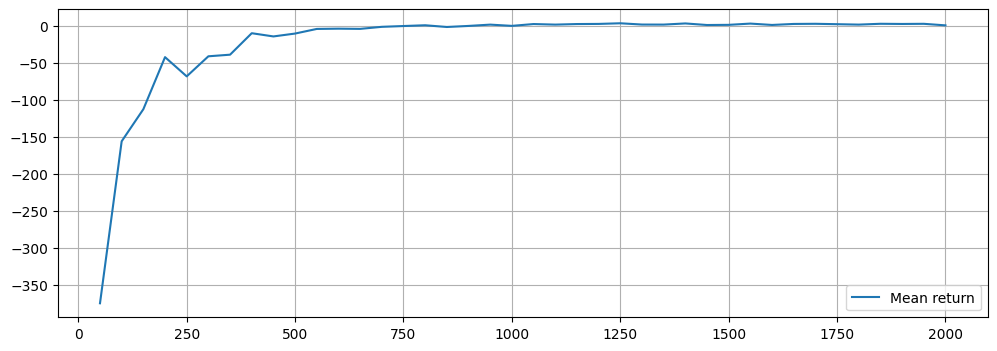

Episode: 2000, Return: 2, AvgReturn[50]: 1


In [131]:
env = gym.make("Taxi-v3")
seed = 1337
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.05, gamma=0.975, eps=0.1, seed=seed,
    f_model=Model
)
log_dyna_q = train(env, agent, n_episodes=2001, on_model_updates=10, seed=seed)

## Dyna-Q with imperfect model

Давайте теперь представим, что мы не знаем ничего о среде (например, что она детерминированная), и будем учить переходы $\alpha$-обучением, то есть с некоторым learning rate'ом.

In [135]:
class ImperfectModel(Model):
    def __init__(self, n_states, n_actions, lr: float, seed: int):
        super().__init__(n_states, n_actions, seed)
        # адаптируйте структуру модели так, чтобы переход (s, a) -> next_s обучался со скоростью `lr`
        """<codehere>"""
        self.lr = lr
        self.mask_state_action = np.zeros((n_states, n_actions), dtype=float)
        """</codehere>"""

    def add(self, s: int, a: int, r: float, next_s: int) -> float:
        # реализуйте шаг обучения модели, причем переход (s, a) -> next_s обучается со скоростью `lr`
        # для простоты функцию вознаграждения обучайте мгновенно
        """<codehere>"""
        self.r[next_s] = r
        self.next_s[s][a] = next_s
        self.mask_state[s] += 1
        # old:
        # self.mask_state_action[s][a] = 1
        self.mask_state_action[s][a] += self.lr * (1 - self.mask_state_action[s][a])
        """</codehere>"""
        return r

    def predict_transition(self, s, a):
        # реализуйте неидеальное предсказание модели перехода: чем менее изучен переход (s, a) -> next_s,
        # тем выше вероятность случайного предсказания.
        """<codehere>"""
        anomaly_prob = 1 - self.mask_state_action[s][a]
        if self._rng.random() < anomaly_prob:
            next_s = self._rng.choice(self.mask_state.size)
        else:
            next_s = self.next_s[s][a]
        """</codehere>"""
        return self.r[s, a], next_s

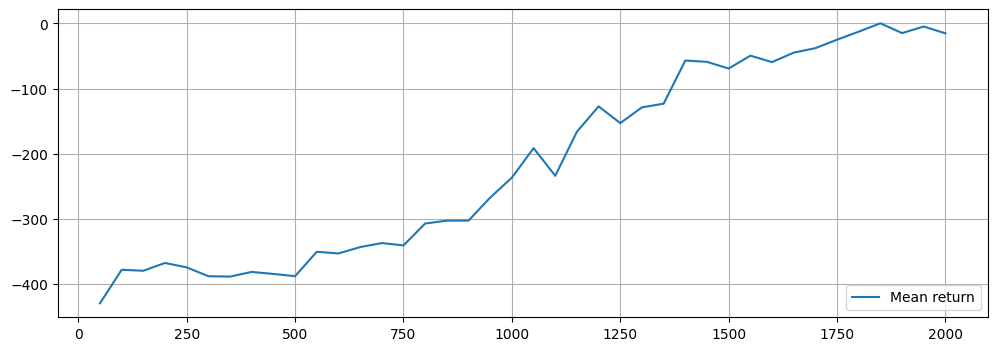

Episode: 2000, Return: 2, AvgReturn[50]: -15


In [136]:
env = gym.make("Taxi-v3")
seed = 1337
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.05, gamma=0.975, eps=0.1, seed=seed,
    f_model=partial(ImperfectModel, lr=0.1)
)

log_dyna_q_imp = train(env, agent, n_episodes=2001, on_model_updates=10, seed=seed)

## Dyna-Q with imperfect model and prediction error based intrinsic motivation

Сигнал ошибки модели является хорошим сигналом мотивации к исследованию, "отправляя" агента в недоисследованные зоны пространства состояний. Как следствие два плюса: а) более быстрое и целенаправленное обучение модели среды (которая дает бонус к скорости обучению через обучение в воображении) и б) более целенаправленное исследование самой среды, которое поможет агенту быстрее найти состояния с высоким внешним вознаграждением.

Давайте посмотрим, так ли это. Реализуйте аналогичную предыдущему пункту "неидеальную" внутреннюю модель среды агента, но теперь также добавьте в нее внутреннюю мотивацию. Для этого можно, например, добавлять ошибку предсказания $1 - P[s_{t+1} |s_t,a_t]$ к полученному внешнему вознаграждению $r_{t+1}$ при обучении функции вознаграждения.

In [140]:
class IntrinsicMotivationModel(ImperfectModel):
    def __init__(self, n_states, n_actions, lr: float, seed: int, add_intrinsic: float=0.):
        super().__init__(n_states, n_actions, lr, seed)
        self.add_intrinsic = add_intrinsic

    def add(self, s: int, a: int, r: float, next_s: int) -> float:
        # вычислите значение сигнала внутренней мотивации r_im
        # можете адаптировать код ниже. Здесь предлагается добавлять его только в случае, если переход
        # почти совсем не выучен, т.е. находится между 0. и learned_threshold
        learned_threshold = 0.25
        if self.add_intrinsic > 0. and self.mask_state_action[s][a] < learned_threshold:
            """<codehere>"""
            r_im = 1 - self.mask_state_action[s][a]**2
            """</codehere>"""
            r += self.add_intrinsic * r_im
        return super().add(s, a, r, next_s)

Сначала возьмем задачу попроще и проверим, что все работает

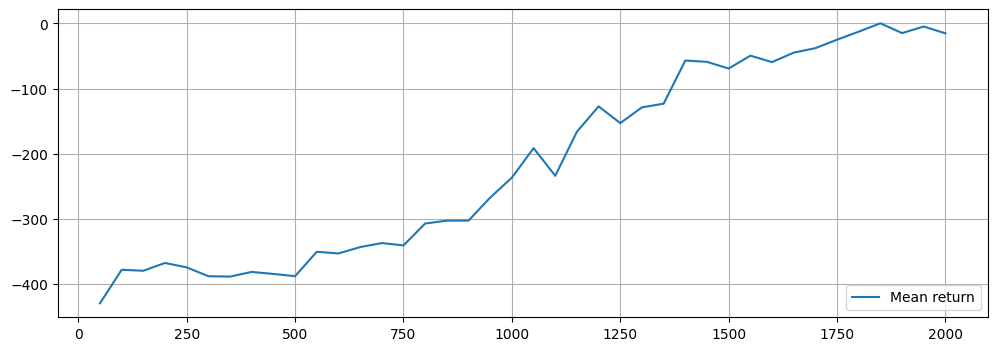

Episode: 2000, Return: 2, AvgReturn[50]: -15


In [138]:
env = gym.make("Taxi-v3")
seed = 1337
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.05, gamma=0.975, eps=0.1, seed=seed,
    f_model=partial(IntrinsicMotivationModel, lr=0.1, add_intrinsic=0.)
)

log_dyna_q_imp_im = train(env, agent, n_episodes=2001, on_model_updates=10, seed=seed)

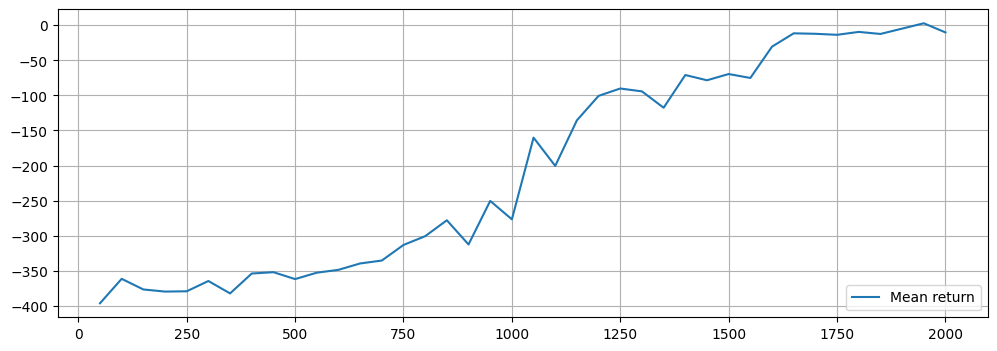

Episode: 2000, Return: -16, AvgReturn[50]: -10


In [142]:
# а теперь со включенной внутренней мотивацией (см add_intrinsic параметр)
env = gym.make("Taxi-v3")
seed = 1337
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.05, gamma=0.975, eps=0.1, seed=seed,
    f_model=partial(IntrinsicMotivationModel, lr=0.1, add_intrinsic=1.)
)

log_dyna_q_imp_im = train(env, agent, n_episodes=2001, on_model_updates=10, seed=seed)

## With imaginary trajectories
До этого процесс обучения в воображении происходил беспорядочно — агент случайно сэмплировал состояние, которое ему знакомо, воображал переход и обучался на одном переходе. Теперь давайте попробуем воспроизвести процесс обучения в воображении, похожий на сновидение — чтобы агент воображал целую траекторию, начинающуюся с текущего состояния (то есть додумывал/планировал возможное продолжение событий, начиная с текущего момента).

In [143]:
class DynaQDreamerAgent(DynaQAgent):
    def dream(self, max_steps, state):
        # текущее состояние — стартовое для траектории длины max_steps в воображении
        s = state
        for _ in range(max_steps):
            # добавьте последовательный шаг в воображении
            """<codehere>"""
            a = self.act(s)
            r, next_s = self.model.predict_transition(s, a)
            self.update(s, a, r, next_s, update_model=False)
            """</codehere>"""
            s = next_s

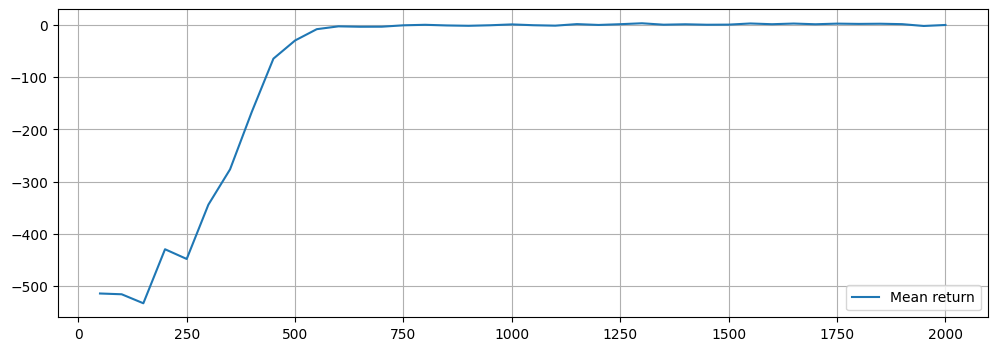

Episode: 2000, Return: -6, AvgReturn[50]: -0


In [144]:
env = gym.make("Taxi-v3")
seed = 1337
agent = DynaQDreamerAgent(
    env.observation_space.n, env.action_space.n, lr=0.05, gamma=0.975, eps=0.1, seed=seed,
    f_model=partial(IntrinsicMotivationModel, lr=0.1, add_intrinsic=0.)
)

log_dyna_q_imp_im_dreamer = train(env, agent, n_episodes=2001, on_model_updates=10, seed=seed)

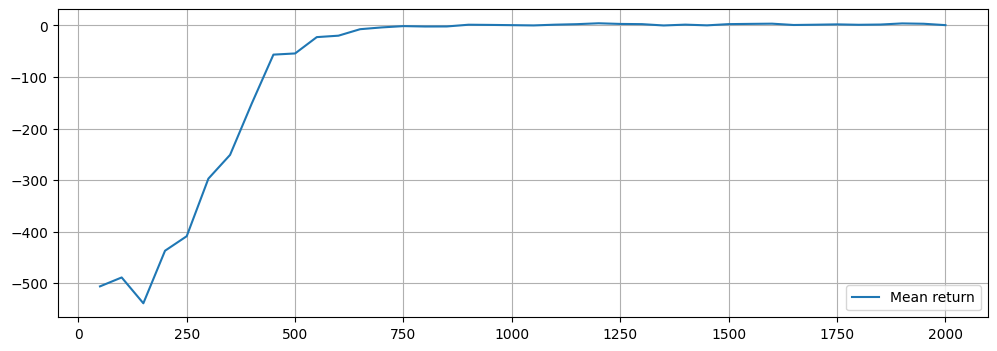

Episode: 2000, Return: 4, AvgReturn[50]: 1


In [146]:
# And the same but with IM turned on
env = gym.make("Taxi-v3")
seed = 1337
agent = DynaQDreamerAgent(
    env.observation_space.n, env.action_space.n, lr=0.05, gamma=0.975, eps=0.1, seed=seed,
    f_model=partial(IntrinsicMotivationModel, lr=0.1, add_intrinsic=.1)
)

log_dyna_q_imp_im_dreamer = train(env, agent, n_episodes=2001, on_model_updates=10, seed=seed)

## Let's wrap up by comparing them side-by-side
Теперь сэмулируем задачу посложнее и сравним результаты (обратите внимание на параметры eps и lr)

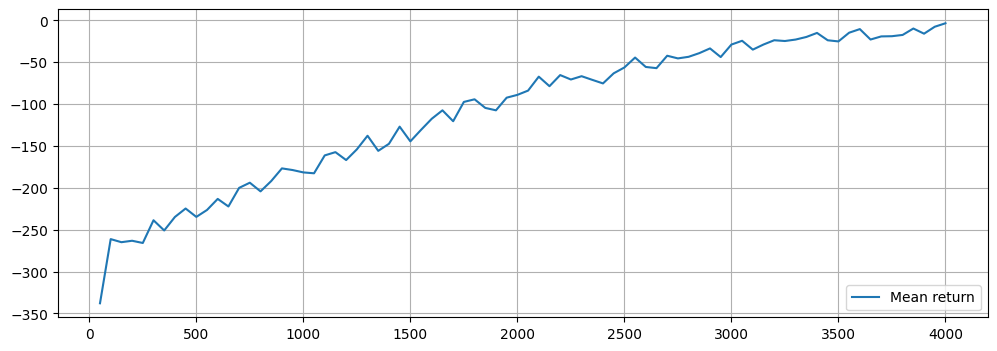

Episode: 4000, Return: 10, AvgReturn[50]: -3


In [147]:
env = gym.make("Taxi-v3")
seed = 42
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.02, gamma=0.975, eps=0.02, seed=seed,
    f_model=Model
)

log_q = train(env, agent, n_episodes=4001, on_model_updates=0, seed=seed, show_progress_schedule=50)

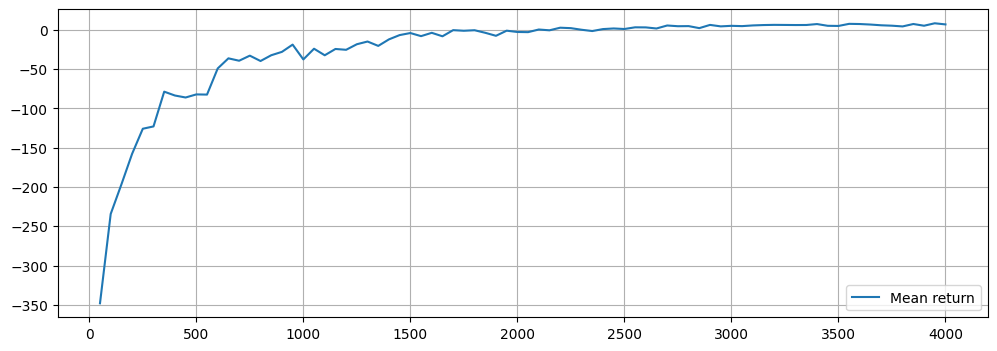

Episode: 4000, Return: 10, AvgReturn[50]: 7


In [148]:
env = gym.make("Taxi-v3")
seed = 42
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.02, gamma=0.975, eps=0.02, seed=seed,
    f_model=Model
)
log_dyna_q = train(env, agent, n_episodes=4001, on_model_updates=4, seed=seed)

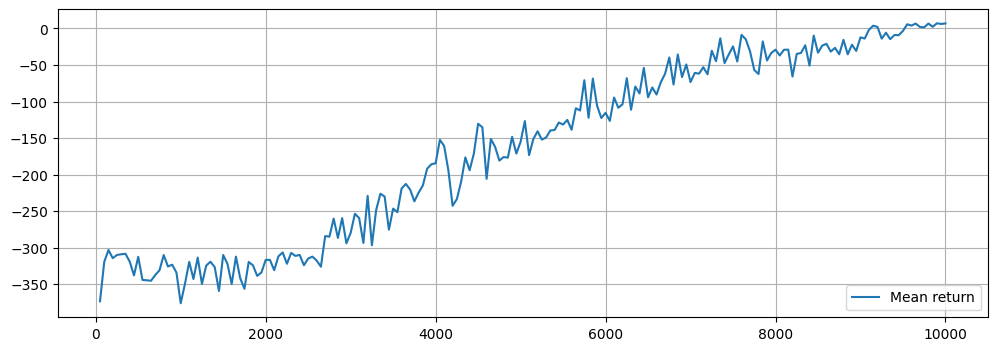

Episode: 10000, Return: 8, AvgReturn[50]: 7


In [149]:
env = gym.make("Taxi-v3")
seed = 42
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.02, gamma=0.975, eps=0.02, seed=seed,
    f_model=partial(ImperfectModel, lr=0.02)
)

log_dyna_q_imp = train(env, agent, n_episodes=10001, on_model_updates=4, seed=seed)

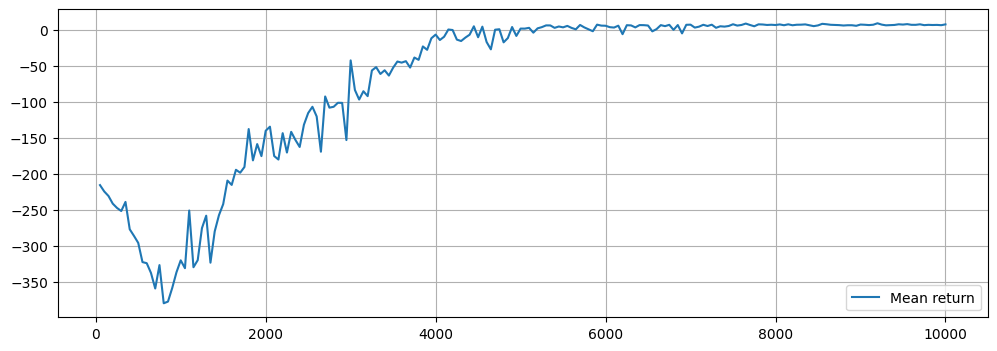

Episode: 10000, Return: 8, AvgReturn[50]: 7


In [150]:
env = gym.make("Taxi-v3")
seed = 42
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.02, gamma=0.975, eps=0.02, seed=seed,
    f_model=partial(IntrinsicMotivationModel, lr=0.02, add_intrinsic=5.)
)

log_dyna_q_imp_im = train(env, agent, n_episodes=10001, on_model_updates=4, seed=seed)

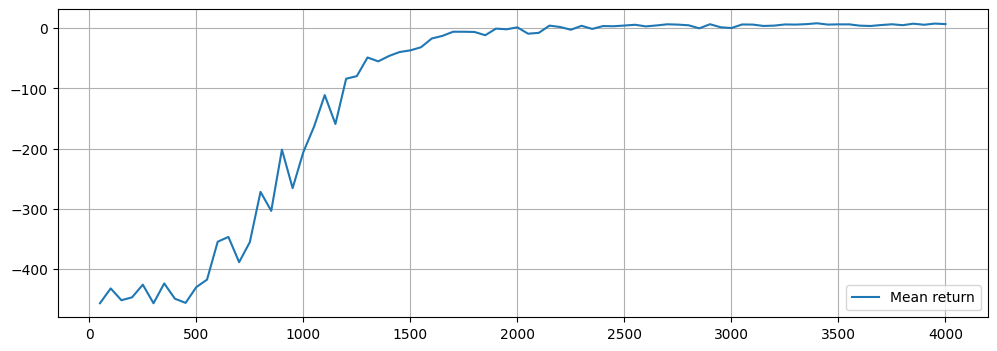

Episode: 4000, Return: 5, AvgReturn[50]: 7


In [151]:
env = gym.make("Taxi-v3")
seed = 42
agent = DynaQDreamerAgent(
    env.observation_space.n, env.action_space.n, lr=0.02, gamma=0.975, eps=0.02, seed=seed,
    f_model=partial(IntrinsicMotivationModel, lr=0.02, add_intrinsic=0.)
)

log_dyna_q_imp_dreamer = train(env, agent, n_episodes=4001, on_model_updates=4, seed=seed)

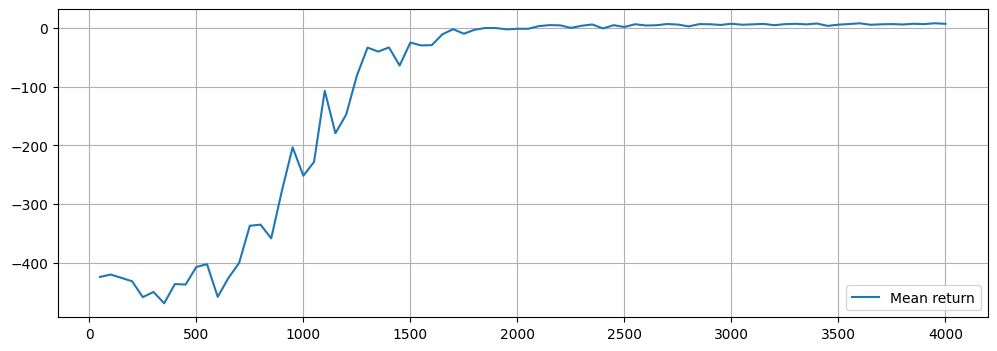

Episode: 4000, Return: 8, AvgReturn[50]: 7


In [168]:
env = gym.make("Taxi-v3")
seed = 42
agent = DynaQDreamerAgent(
    env.observation_space.n, env.action_space.n, lr=0.02, gamma=0.975, eps=0.02, seed=seed,
    f_model=partial(IntrinsicMotivationModel, lr=0.02, add_intrinsic=.25)
)

log_dyna_q_imp_im_dreamer = train(env, agent, n_episodes=4001, on_model_updates=4, seed=seed)

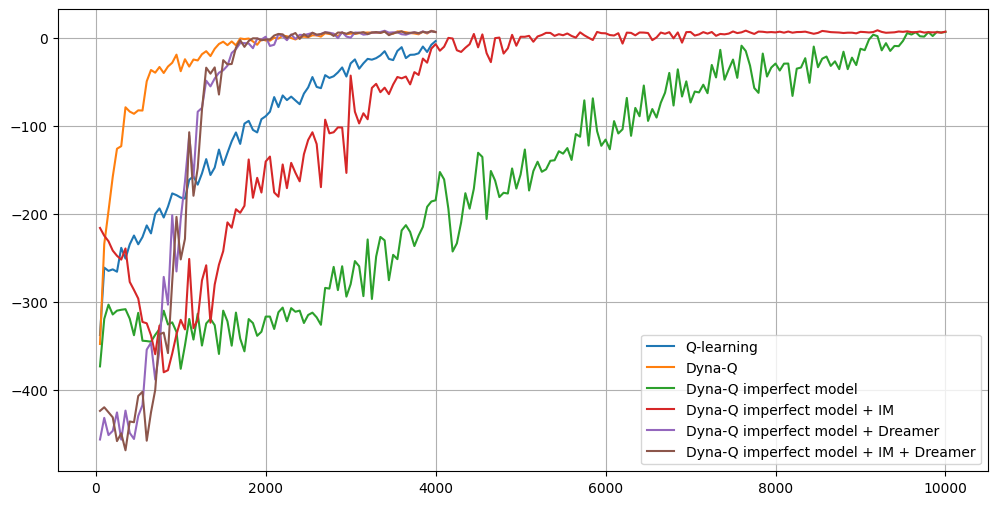

In [169]:
compare_logs([
    (log_q, 'Q-learning'),
    (log_dyna_q, 'Dyna-Q'),
    (log_dyna_q_imp, 'Dyna-Q imperfect model'),
    (log_dyna_q_imp_im, 'Dyna-Q imperfect model + IM'),
    (log_dyna_q_imp_dreamer, 'Dyna-Q imperfect model + Dreamer'),
    (log_dyna_q_imp_im_dreamer, 'Dyna-Q imperfect model + IM + Dreamer'),
])

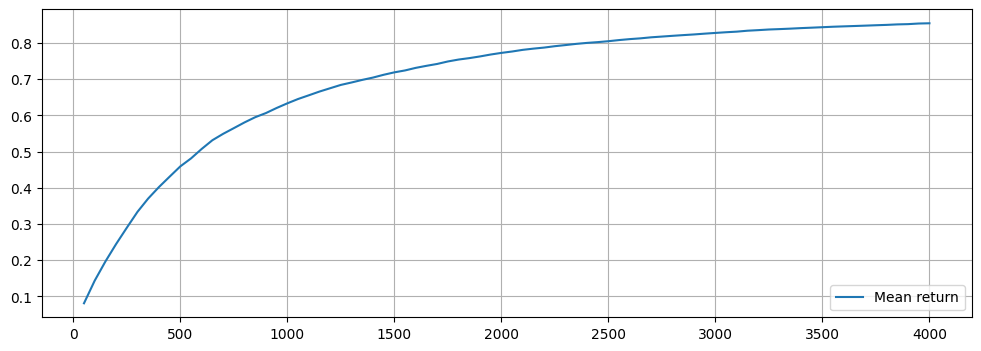

In [170]:
env = gym.make("Taxi-v3")
seed = 42
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.02, gamma=0.975, eps=0.02, seed=seed,
    f_model=partial(ImperfectModel, lr=0.02)
)

log_dyna_q_imp = train(env, agent, n_episodes=4001, on_model_updates=4, seed=seed, show_model_progres=True)

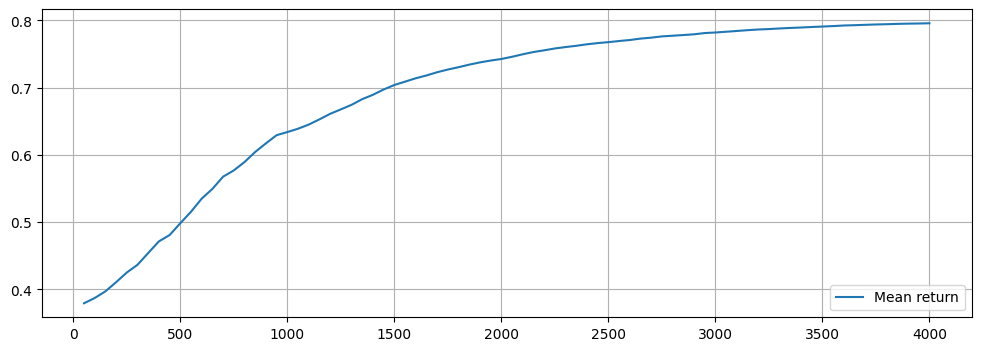

In [171]:
env = gym.make("Taxi-v3")
seed = 42
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.02, gamma=0.975, eps=0.02, seed=seed,
    f_model=partial(IntrinsicMotivationModel, lr=0.02, add_intrinsic=5.)
)

log_dyna_q_imp_im = train(env, agent, n_episodes=4001, on_model_updates=4, seed=seed, show_model_progres=True)

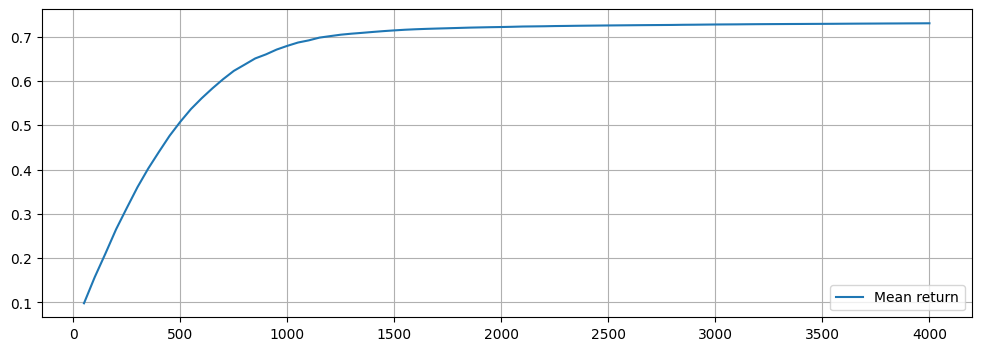

In [172]:
env = gym.make("Taxi-v3")
seed = 42
agent = DynaQDreamerAgent(
    env.observation_space.n, env.action_space.n, lr=0.02, gamma=0.975, eps=0.02, seed=seed,
    f_model=partial(IntrinsicMotivationModel, lr=0.02, add_intrinsic=0.)
)

log_dyna_q_imp_dreamer = train(env, agent, n_episodes=4001, on_model_updates=4, seed=seed, show_model_progres=True)

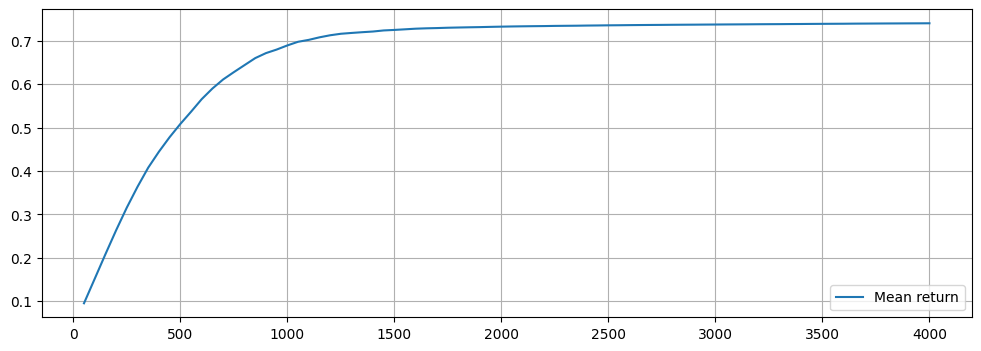

In [173]:
env = gym.make("Taxi-v3")
seed = 42
agent = DynaQDreamerAgent(
    env.observation_space.n, env.action_space.n, lr=0.02, gamma=0.975, eps=0.02, seed=seed,
    f_model=partial(IntrinsicMotivationModel, lr=0.02, add_intrinsic=.25)
)

log_dyna_q_imp_im_dreamer = train(env, agent, n_episodes=4001, on_model_updates=4, seed=seed, show_model_progres=True)

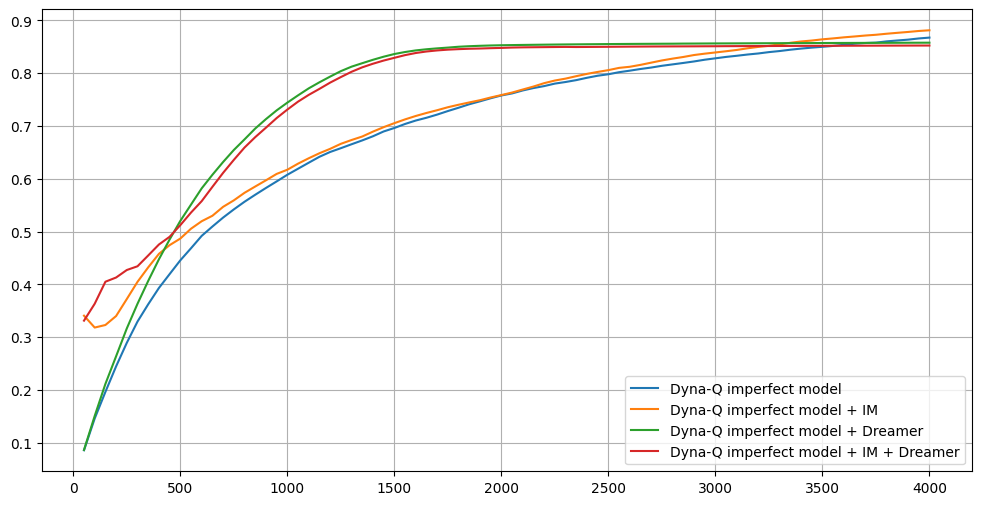

In [78]:
compare_logs([
    (log_dyna_q_imp, 'Dyna-Q imperfect model'),
    (log_dyna_q_imp_im, 'Dyna-Q imperfect model + IM'),
    (log_dyna_q_imp_dreamer, 'Dyna-Q imperfect model + Dreamer'),
    (log_dyna_q_imp_im_dreamer, 'Dyna-Q imperfect model + IM + Dreamer'),
])

In [175]:
"""<comment>"""
from codehere import convert
import os

os.makedirs('render', exist_ok=True)

nb_name = '03-2.mbrl'
convert(
    file=f'{nb_name}.ipynb',
    outfile=f'render/{nb_name}.ipynb',
    clear=True, replacement=" Здесь ваш код "
)
convert(
    file=f'{nb_name}.ipynb',
    outfile=f'render/{nb_name}-solution.ipynb',
    clear=True, solution=True, replacement=" Здесь ваш код "
)
"""</comment>"""

Saved in:  render/03-2.mbrl.ipynb
Saved in:  render/03-2.mbrl-solution.ipynb


'</comment>'